2025-04-16 17:40:19.417157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 17:40:19.652399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 17:40:19.718988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 17:40:20.229113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 17:40:22.510600: W tensorflow/compiler/tf2

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/home/chebolu_srikanth/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744805428.162651    1088 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Feature matrix shape: (4206, 32)
Target vector shape: (4206,)


2025-04-16 17:40:28.710456: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0144 
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1875e-05
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2424e-05
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8470e-05
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5331e-05
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2948e-05
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3217e-05
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2747e-05
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3701e-05
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2525e-05
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0611e-05
Epoch 12/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1378e-05
Epoch 13/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0958e-05
Epoch 14/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1

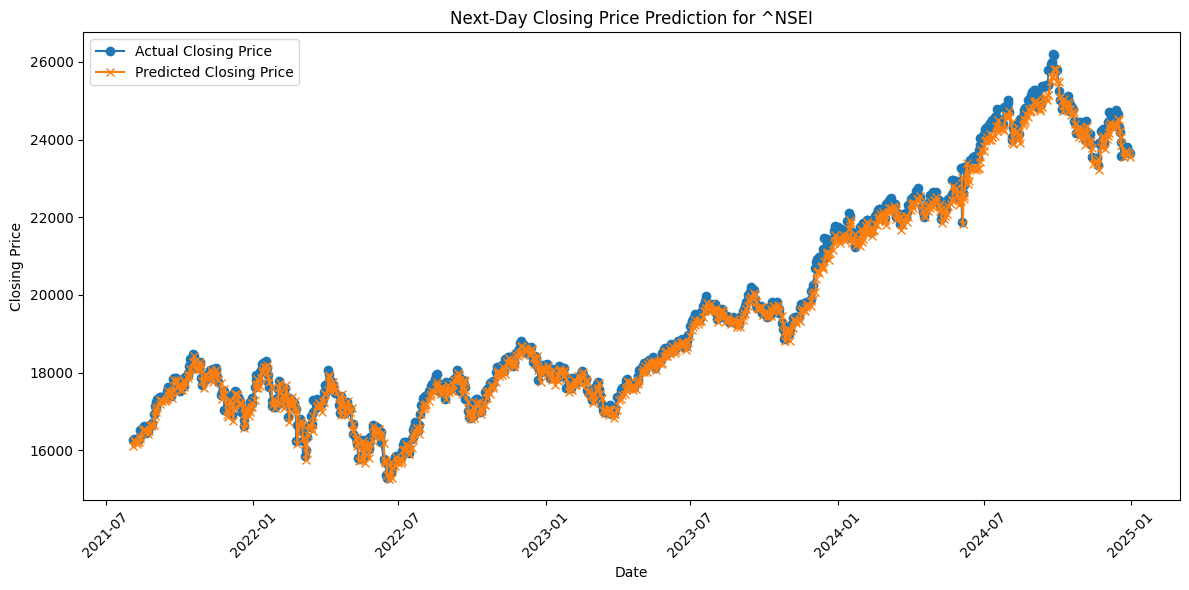

Predicted Close Value of the Next Day: 23552.041


In [1]:
#  APPROACH -->  1


import numpy as np
import pandas as pd
import pywt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

ticker = '^NSEI'
start_date = '2007-09-17'
end_date = '2025-01-01'
data = yf.download(ticker, start=start_date, end=end_date)

data.sort_index(inplace=True)

data.reset_index(inplace=True)
df = data[['Date', 'Close']]

closing_prices = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_prices = scaler.fit_transform(closing_prices).flatten()

def compute_wavelet_features(window, wavelet='haar', level=2):

    coeffs = pywt.wavedec(window, wavelet, level=level)
    return np.concatenate(coeffs)

window_size = 32

X = []
y = []
for i in range(len(normalized_prices) - window_size):
    window = normalized_prices[i:i + window_size]
    features = compute_wavelet_features(window, wavelet='haar', level=2)
    X.append(features)
    y.append(normalized_prices[i + window_size])

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = Sequential()
input_dim = X_train.shape[1]
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])

test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Test MSE (normalized scale):", test_loss)

y_test_pred = model.predict(X_test).flatten()

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

test_dates = df['Date'][window_size + split_index: window_size + split_index + len(y_test_inv)]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual Closing Price', marker='o')
plt.plot(test_dates, y_pred_inv, label='Predicted Closing Price', marker='x')
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"Next-Day Closing Price Prediction for {ticker}")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

next_day_close = y_pred_inv[-1]
print("Predicted Close Value of the Next Day:", next_day_close)

[*********************100%***********************]  1 of 1 completed
/home/chebolu_srikanth/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Feature matrix shape: (7242, 32)
Target vector shape: (7242,)
Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6473e-05
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7126e-04
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2945e-05
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5620e-04
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6479e-05
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5485e-05
Epoch 8/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2382e-05
Epoch 9/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6605e-04
Epoch 10/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4735e-04
Epoch 11/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0253e-05
Epoch 12/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4774e-04
Epoch 13/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0509e-04
Ep

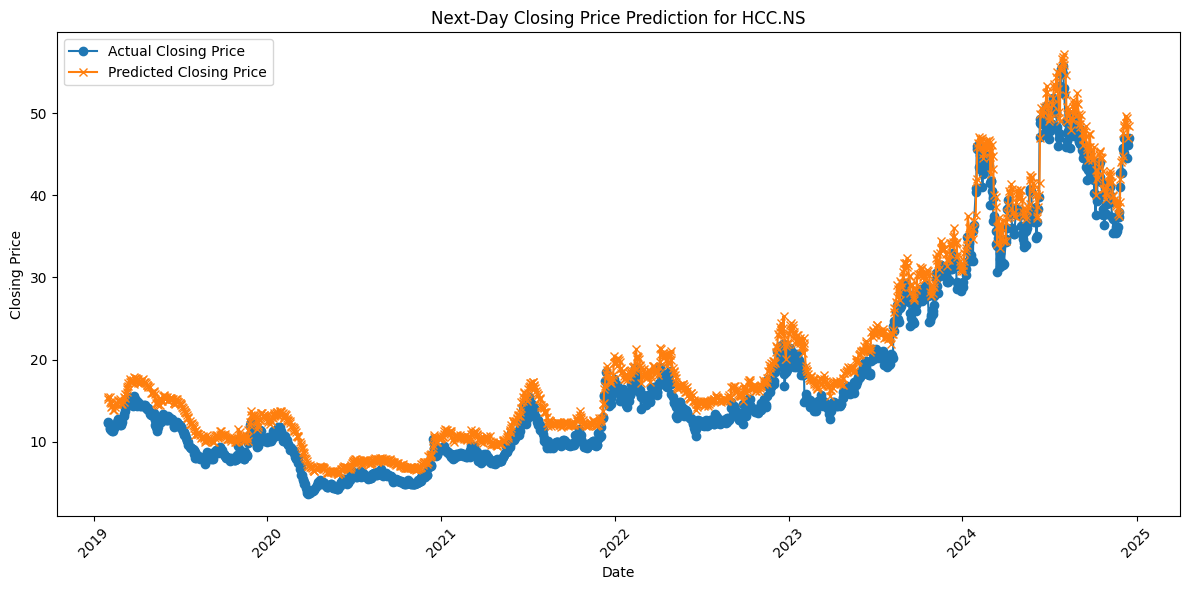

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


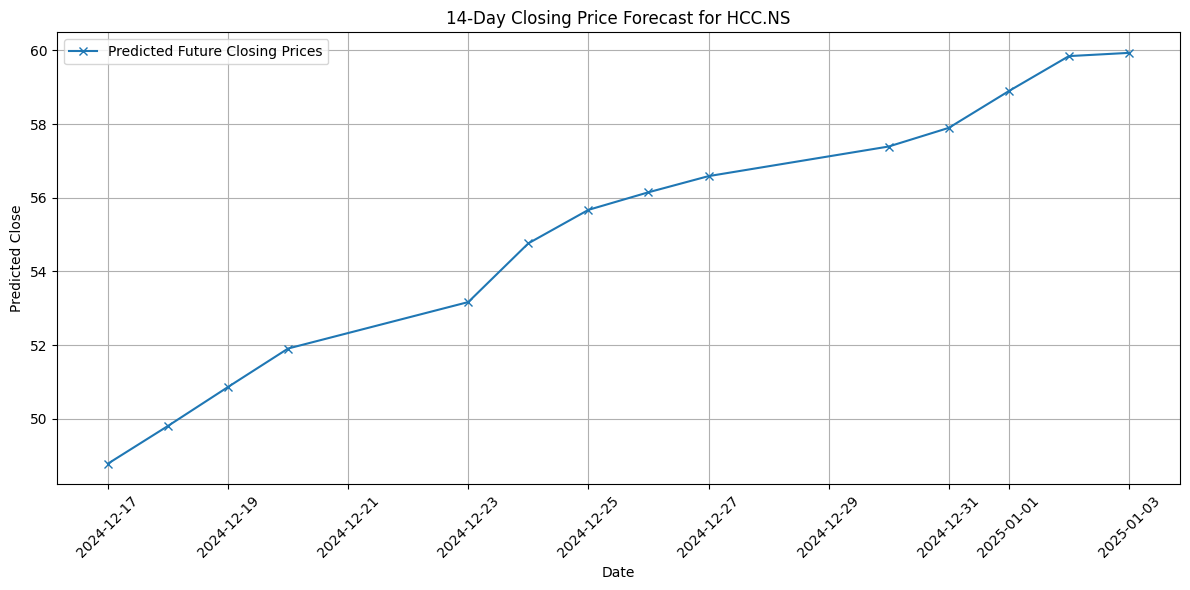

Predicted closing prices for the next 14 days:
2024-12-17 --> 48.78
2024-12-18 --> 49.81
2024-12-19 --> 50.86
2024-12-20 --> 51.91
2024-12-23 --> 53.17
2024-12-24 --> 54.76
2024-12-25 --> 55.67
2024-12-26 --> 56.15
2024-12-27 --> 56.59
2024-12-30 --> 57.39
2024-12-31 --> 57.90
2025-01-01 --> 58.90
2025-01-02 --> 59.85
2025-01-03 --> 59.93


In [ ]:
import numpy as np
import pandas as pd
import pywt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

ticker = 'HCC.NS'
start_date = '1996-01-01'
end_date = '2024-12-17'
data = yf.download(ticker, start=start_date, end=end_date)

data.sort_index(inplace=True)
data.reset_index(inplace=True)
df = data[['Date', 'Close']]

closing_prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_prices = scaler.fit_transform(closing_prices).flatten()

def compute_wavelet_features(window, wavelet='haar', level=2):
    coeffs = pywt.wavedec(window, wavelet, level=level)
    return np.concatenate(coeffs)

window_size = 32
X = []
y = []

for i in range(len(normalized_prices) - window_size):
    window = normalized_prices[i:i + window_size]
    features = compute_wavelet_features(window)
    X.append(features)
    y.append(normalized_prices[i + window_size])

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = Sequential()
input_dim = X_train.shape[1]
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])

test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Test MSE (normalized scale):", test_loss)

y_test_pred = model.predict(X_test).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

test_dates = df['Date'][window_size + split_index: window_size + split_index + len(y_test_inv)]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual Closing Price', marker='o')
plt.plot(test_dates, y_pred_inv, label='Predicted Closing Price', marker='x')
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"Next-Day Closing Price Prediction for {ticker}")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


future_predictions = []
last_window = normalized_prices[-window_size:].tolist()

for _ in range(14):
    features = compute_wavelet_features(np.array(last_window))
    features = features.reshape(1, -1)
    next_pred = model.predict(features)[0, 0]

    future_predictions.append(next_pred)

    last_window.append(next_pred)
    last_window = last_window[1:]

future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=14, freq='B') 

plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_inv, label='Predicted Future Closing Prices', marker='x')
plt.xlabel("Date")
plt.ylabel("Predicted Close")
plt.title(f"14-Day Closing Price Forecast for {ticker}")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Predicted closing prices for the next 14 days:")
for date, price in zip(future_dates, future_predictions_inv):
    print(f"{date.date()} --> {price:.2f}")